In [14]:
import keras, os, pickle, re, sklearn, string, tensorflow
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split


print('Keras version: \t\t%s' % keras.__version__)
print('Scikit version: \t%s' % sklearn.__version__)
print('TensorFlow version: \t%s' % tensorflow.__version__)

Keras version: 		2.2.0
Scikit version: 	0.19.1
TensorFlow version: 	1.8.0


### Parameter

In [15]:
# EMBEDDING
MAX_NUM_WORDS  = 20000
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 200
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [100,150,200]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.2

### Preprocessing

In [16]:
def clean_doc(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Removing short words
    """
    stop_words = set(stopwords.words('english'))
    
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def read_files(path):
    documents = list()
    # Read in all files in directory
    if os.path.isdir(path):
        for filename in os.listdir(path):
            with open('%s/%s' % (path, filename)) as f:
                doc = f.read()
                doc = clean_doc(doc)
                documents.append(doc)
    
    # Read in all lines in a txt file
    if os.path.isfile(path):        
        with open(path, encoding='iso-8859-1') as f:
            doc = f.readlines()
            for line in doc:
                documents.append(clean_doc(line))
    return documents

In [4]:
import pandas as pd
cdf = pd.read_csv("cDMARD Neutral vs Opinion.csv")
bdf = pd.read_csv("bDMARD Neutral vs Opinion.csv")


cdfwithOpinion = cdf[cdf.CNN_prediction >0.41]
bdfWithOpinion = bdf[(bdf.CNN_prediction>0.4)& (bdf.Manual !=-1)]

pos_doc = list(cdfwithOpinion.tweet[(cdfwithOpinion.Vaderfixed >=0.65)]) + \
    list(bdfWithOpinion.tweet[((bdfWithOpinion.Vaderfixed >=0.65) & (bdfWithOpinion.Manual !=-1))|(bdfWithOpinion.Manual ==1)]) 

neg_doc = list(cdfwithOpinion.tweet[(cdfwithOpinion.Vaderfixed <=-0.65)]) + \
    list(bdfWithOpinion.tweet[((bdfWithOpinion.Vaderfixed <=-0.65)& (bdfWithOpinion.Manual !=-1))|(bdfWithOpinion.Manual ==0)]) 

In [7]:
print("neg doc", len(neg_doc))
print("pos doc", len(pos_doc))


neg doc 2335
pos doc 3950


In [8]:
EntireDocs = pos_doc + neg_doc

EntireLabels = [0 for _ in range(len(neg_doc))] + [1 for _ in range(len(pos_doc))]

In [9]:
from sklearn.utils import shuffle

EntireDocs, EntireLabels= shuffle(EntireDocs, EntireLabels)
docs, X_test, labels, y_test  = train_test_split(EntireDocs, EntireLabels, test_size=VAL_SIZE, random_state=2311
                                                )

## Tokenizer

In [18]:
def max_length(lines):
    """
    Calculate the maximum document length
    """
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)

length = max_length(docs)
word_index = tokenizer.word_index

result = [len(x.split()) for x in docs]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 75 / min length: 3 / mean length: 22 / limit length: 200
vacobulary size: 10881 / limit: 20000


## Embeddings

In [19]:
def create_glove_embeddings():
    print('Pretrained embeddings GloVe is loading...')

    embeddings_index = {}
    f = open('myGlove300.txt', 'r', encoding = 'utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

## Model definition

## Training

In [20]:
import cnn_model

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=VAL_SIZE, random_state=42)
    
    
    emb_layer = None
    if USE_GLOVE:
        emb_layer = create_glove_embeddings()
    
    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint('model-PN-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    print()
    histories.append(history.history)

Running iteration 1/5
Pretrained embeddings GloVe is loading...
Found 20754 word vectors in GloVe embedding
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 20000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [100, 150, 200]
Max sequence: 200
#############################################
Train on 4022 samples, validate on 1006 samples
Epoch 1/40
4022/4022 [==============================] - 228s 57ms/step - loss: 10.9664 - acc: 0.6124 - val_loss: 5.2341 - val_acc: 0.6392

Epoch 00001: val_loss improved from inf to 5.23412, saving model to model-PN-1.h5
Epoch 2/40
4022/4022 [==============================] - 236s 59ms/step - loss: 3.2630 - acc: 0.6290 - val_loss: 1.8021 - val_acc: 0.6183

Epoch 00002: val_loss improved from 5.23412 to 1.80208, saving model to model-PN-1.h5
Epoch 3/40
4022/4022 [==============================] - 227s 56ms/step - loss: 1.2891 - acc: 0.6325 - val_loss: 0.9676 - val_acc: 0.


Epoch 00034: val_loss improved from 0.50043 to 0.49884, saving model to model-PN-2.h5
Epoch 35/40
4022/4022 [==============================] - 124s 31ms/step - loss: 0.4552 - acc: 0.8046 - val_loss: 0.4968 - val_acc: 0.7714

Epoch 00035: val_loss improved from 0.49884 to 0.49683, saving model to model-PN-2.h5
Epoch 36/40
4022/4022 [==============================] - 125s 31ms/step - loss: 0.4573 - acc: 0.8011 - val_loss: 0.5025 - val_acc: 0.7575

Epoch 00036: val_loss did not improve from 0.49683
Epoch 37/40
4022/4022 [==============================] - 124s 31ms/step - loss: 0.4540 - acc: 0.8103 - val_loss: 0.4961 - val_acc: 0.7684

Epoch 00037: val_loss improved from 0.49683 to 0.49609, saving model to model-PN-2.h5
Epoch 38/40
4022/4022 [==============================] - 124s 31ms/step - loss: 0.4512 - acc: 0.8118 - val_loss: 0.4947 - val_acc: 0.7763

Epoch 00038: val_loss improved from 0.49609 to 0.49475, saving model to model-PN-2.h5
Epoch 39/40
4022/4022 [=========================


Epoch 00028: val_loss did not improve from 0.49851
Epoch 29/40
4022/4022 [==============================] - 122s 30ms/step - loss: 0.4497 - acc: 0.8115 - val_loss: 0.4958 - val_acc: 0.7753

Epoch 00029: val_loss improved from 0.49851 to 0.49582, saving model to model-PN-4.h5
Epoch 30/40
4022/4022 [==============================] - 122s 30ms/step - loss: 0.4486 - acc: 0.8061 - val_loss: 0.4955 - val_acc: 0.7744

Epoch 00030: val_loss improved from 0.49582 to 0.49546, saving model to model-PN-4.h5
Epoch 31/40
4022/4022 [==============================] - 122s 30ms/step - loss: 0.4413 - acc: 0.8215 - val_loss: 0.4911 - val_acc: 0.7783

Epoch 00031: val_loss improved from 0.49546 to 0.49107, saving model to model-PN-4.h5
Epoch 32/40
4022/4022 [==============================] - 122s 30ms/step - loss: 0.4380 - acc: 0.8202 - val_loss: 0.4908 - val_acc: 0.7744

Epoch 00032: val_loss improved from 0.49107 to 0.49076, saving model to model-PN-4.h5
Epoch 33/40
4022/4022 [=========================

Epoch 26/40
4022/4022 [==============================] - 198s 49ms/step - loss: 0.4375 - acc: 0.8312 - val_loss: 0.5006 - val_acc: 0.7744

Epoch 00026: val_loss improved from 0.51243 to 0.50058, saving model to model-PN-5.h5
Epoch 27/40
4022/4022 [==============================] - 204s 51ms/step - loss: 0.4349 - acc: 0.8314 - val_loss: 0.5025 - val_acc: 0.7823

Epoch 00027: val_loss did not improve from 0.50058
Epoch 28/40
4022/4022 [==============================] - 194s 48ms/step - loss: 0.4299 - acc: 0.8337 - val_loss: 0.4933 - val_acc: 0.7734

Epoch 00028: val_loss improved from 0.50058 to 0.49335, saving model to model-PN-5.h5
Epoch 29/40
4022/4022 [==============================] - 161s 40ms/step - loss: 0.4301 - acc: 0.8362 - val_loss: 0.4902 - val_acc: 0.7783

Epoch 00029: val_loss improved from 0.49335 to 0.49024, saving model to model-PN-5.h5
Epoch 30/40
4022/4022 [==============================] - 141s 35ms/step - loss: 0.4252 - acc: 0.8284 - val_loss: 0.4887 - val_acc: 0.79

In [21]:
with open('PosNeg2.pkl', 'wb') as f:
    pickle.dump(histories, f)

## Evaluation

In [22]:
histories = pickle.load(open('PosNeg2.pkl', 'rb'))

In [46]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	0.3815 loss / 0.8525 acc
Validation: 	0.4601 loss / 0.7984 acc


In [47]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

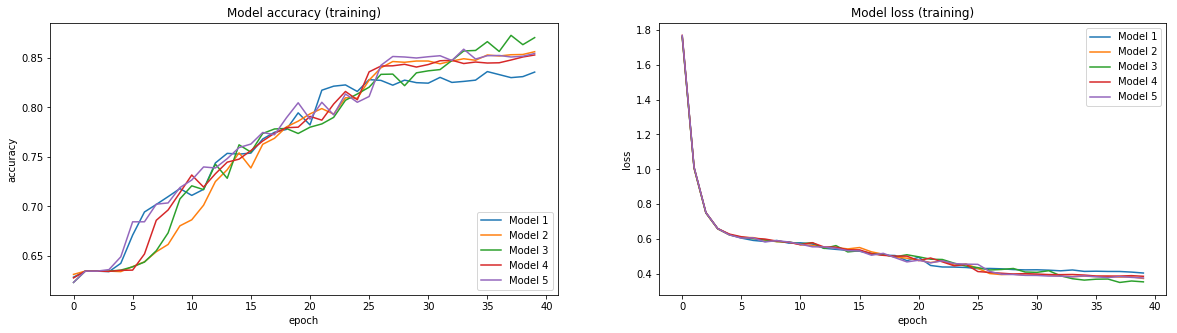

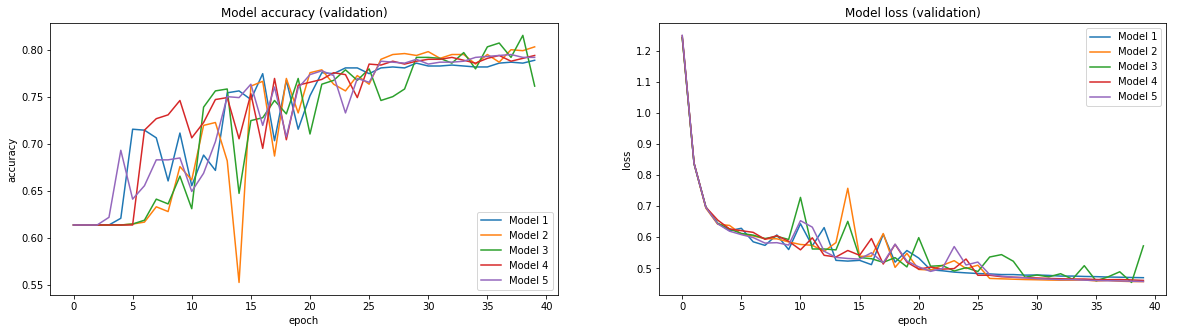

In [45]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

##### Final test 


In [65]:

neg_doc_Test =  list(bdf.tweet[(bdf.polarity >-0.50)  & (bdf.polarity <-0.30)])
pos_doc_Test =  list(bdf.tweet[(bdf.polarity<0.5) & (bdf.polarity >0.3)])

X_test = neg_doc_Test + pos_doc_Test

#X_test = negative_docs_test + positive_docs_test
y_test = [0 for _ in range(len(neg_doc_Test))] + [1 for _ in range(len(pos_doc_Test))]

In [35]:
len(X_test)

666

In [36]:
bdf= pd.read_csv("bDMAR without URL with Vader polarity_Drug name in.csv")
neg_doc_Test = list(bdf.tweet[bdf.Manual ==0])
pos_doc_Test = list(bdf.tweet[bdf.Manual ==1])



X_test = neg_doc_Test + pos_doc_Test

#X_test = negative_docs_test + positive_docs_test
y_test = [0 for _ in range(len(neg_doc_Test))] + [1 for _ in range(len(pos_doc_Test))]

In [48]:
sequences_test = tokenizer.texts_to_sequences(X_test)


X_test = pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

In [49]:
test_loss = []
test_accs = []

for i in range(0,RUNS):
    cnn_ = load_model("model-PN-%i.h5" % (i+1))
    
    score = cnn_.evaluate(X_test, y_test, verbose=1)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

1230/1230 [==============================] - 4s 4ms/step
Running test with model 1: 0.4991 loss / 0.7789 acc
1230/1230 [==============================] - 4s 3ms/step
Running test with model 2: 0.4876 loss / 0.7870 acc
1230/1230 [==============================] - 5s 4ms/step
Running test with model 3: 0.4878 loss / 0.7894 acc
1230/1230 [==============================] - 5s 4ms/step
Running test with model 4: 0.4916 loss / 0.7878 acc
1230/1230 [==============================] - 4s 4ms/step
Running test with model 5: 0.4868 loss / 0.7894 acc

Average loss / accuracy on testset: 0.4906 loss / 0.7865 acc
Standard deviation: (+-0.0046) loss / (+-0.0039) acc


In [50]:
bestModel = load_model("model-PN-5.h5")

In [51]:
bdfText = list(bdfWithOpinion.tweet)
sequences_testB = tokenizer.texts_to_sequences(bdfText)

bdf_text = pad_sequences(sequences_testB, maxlen=MAX_SEQ_LENGTH, padding='post')

bdfPrediction = bestModel.predict(bdf_text)

In [52]:
bdfPred = [i[0] for i  in bdfPrediction]

In [56]:
bdfWithOpinion.columns

Index(['Unnamed: 0', 'tweet', 'CNN_prediction', 'id', 'userID', 'index',
       'Manual', 'Vaderfixed', 'VaderScore'],
      dtype='object')

In [58]:
bdf_cnn = pd.DataFrame({"tweet":bdfText, "CNN_prediction" : bdfPred, "id":bdfWithOpinion.id, "userID":bdfWithOpinion.userID, "index":bdfWithOpinion['index'], "Manual" : bdfWithOpinion.Manual, "Vaderfixed": bdfWithOpinion['Vaderfixed'], "VaderScore": bdfWithOpinion['VaderScore']})

In [60]:
cdfText = list(cdfwithOpinion.tweet)
sequences_testC = tokenizer.texts_to_sequences(cdfText)

cdf_text = pad_sequences(sequences_testC, maxlen=MAX_SEQ_LENGTH, padding='post')

cdfPrediction = bestModel.predict(cdf_text)

cdfPred = [i[0] for i  in cdfPrediction]

In [63]:
cdf_cnn = pd.DataFrame({"tweet":cdfText, "CNN_prediction" : cdfPred, "id":cdfwithOpinion.id, "userID":cdfwithOpinion.userID, "index":cdfwithOpinion['index'], "Vaderfixed": cdfwithOpinion['Vaderfixed'], "VaderScore": cdfwithOpinion['VaderScore']})

In [65]:
bdf_cnn.to_csv("bDMARD with PosNeg.csv")
cdf_cnn.to_csv("cDMARD with PosNeg.csv")